# Analysis of Rain on Snow Database

In [68]:
import sys
sys.path.append('..')

from pathlib import Path

from pqdm.threads import pqdm

import numpy as np
import pandas as pd

# For plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.transforms as transforms

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from ros_database.processing.surface import read_iowa_mesonet_file, load_station_metadata
from ros_database.filepath import SURFOBS_HOURLY_PATH

from notebooks.database_utils import make_observation_counts, make_station_event_counts, heatmap, get_stationid

#from .autonotebook import tqdm as notebook_tqdm

### Load common data

In [2]:
# Paths for hourly station files
station_paths = SURFOBS_HOURLY_PATH.glob("*.hourly.csv")

# Station metadata
stations = load_station_metadata()
country_order = stations.sort_values('country').index.values

## Find data with 24 hours of data

In [3]:
observation_count_fp = Path("aross.database.daily_observation_counts.csv")
if not observation_count_fp.exists():
    make_observation_counts(station_paths)

observation_counts = pd.read_csv(observation_count_fp, index_col=0, parse_dates=True)
observation_counts.tail()

,PAFM,PAKP,CYQH,ESNS,BIKF,UOOO,PAYA,UHMP,ENNA,ESPE,...,BGKK,PAGK,USRR,PAIW,UERP,PABR,PAVD,PFSH,CYDA,CYSM
datetime,,,,,,,,,,,,,,,,,,,,,
2023-11-09,24.0,24.0,24.0,24.0,24.0,24.0,24.0,NaN,24.0,24.0,...,24.0,21.0,24.0,24.0,24.0,17.0,24.0,24.0,10.0,23.0
2023-11-10,24.0,24.0,24.0,24.0,24.0,24.0,24.0,NaN,24.0,24.0,...,24.0,22.0,24.0,24.0,24.0,17.0,24.0,24.0,10.0,24.0
2023-11-11,23.0,24.0,24.0,24.0,24.0,24.0,24.0,NaN,24.0,24.0,...,24.0,24.0,24.0,24.0,24.0,17.0,24.0,24.0,10.0,24.0
2023-11-12,24.0,24.0,24.0,24.0,24.0,24.0,24.0,NaN,24.0,24.0,...,24.0,22.0,24.0,24.0,24.0,15.0,24.0,24.0,10.0,24.0
2023-11-13,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN


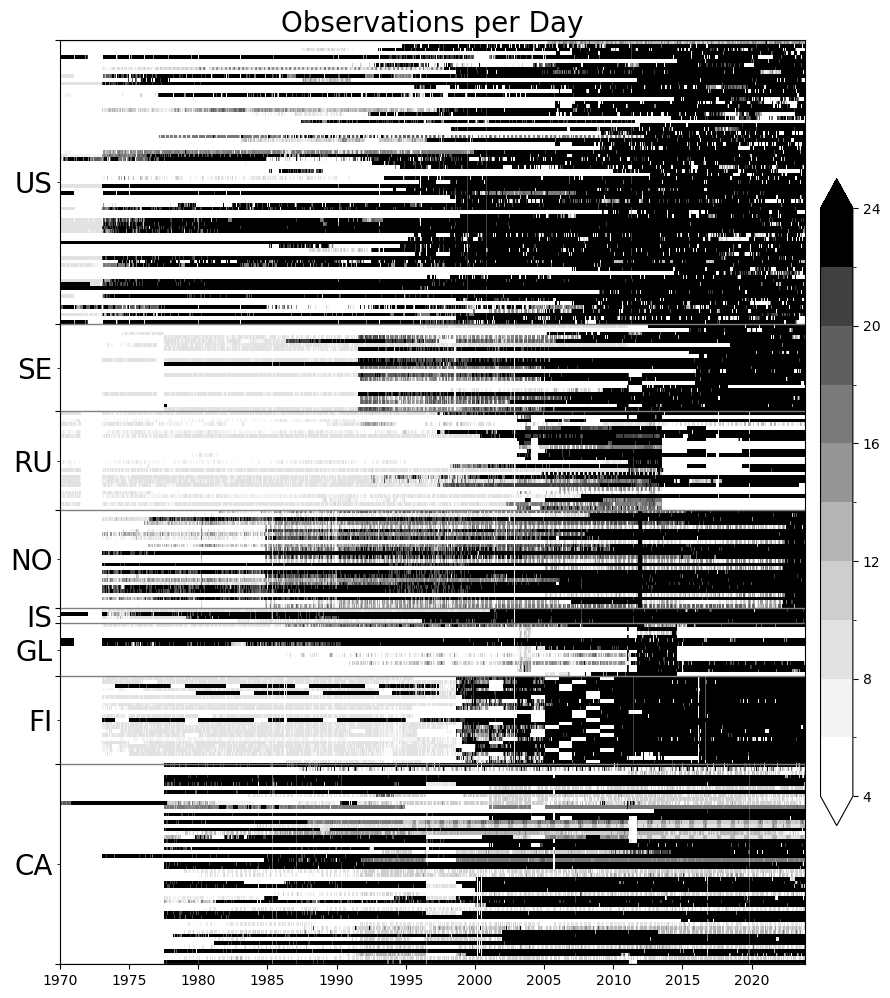

In [4]:
xs = 20
ys = 12
fig, ax = plt.subplots(figsize=(xs, ys))

heatmap(observation_counts.loc[slice("1970","2024"), country_order], fig=fig, ax=ax, 
        levels=[4., 6., 8., 10., 12., 14., 16., 18., 20., 22., 24.], extend="both", cmap='Greys', aspect=100)
ax.set_title("Observations per Day", fontsize=20)
fig.savefig("aross.database.observations_per_day.png")

## Explore total event counts

We generate a `pandasDataFrame` containing total number of events by type for each station

#### Load event counts for stations

In [7]:
station_event_count_fp = Path("station_event_counts_winter.csv")
if not station_event_count_fp.exists():
    make_station_event_counts(season="winter")
total_events = pd.read_csv(station_event_count_fp, index_col=0)
total_events.head()

,UP,RA,FZRA,SOLID,ROS,Total,longitude,latitude
PAFM,606,808,0,11050,808,11858,-157.85747,67.10631
PAKP,291,177,0,13121,177,13298,-151.74334,68.13360
CYQH,0,1307,81,22957,1388,24345,-128.82250,60.11639
ESNS,294,2700,73,12396,2773,15169,21.07694,64.62472
BIKF,0,12639,5,6984,12644,19628,-22.58758,63.97468


## Make map of number of events

array([[<Axes: title={'center': 'UP'}>, <Axes: title={'center': 'RA'}>],
       [<Axes: title={'center': 'FZRA'}>,
        <Axes: title={'center': 'SOLID'}>],
       [<Axes: title={'center': 'ROS'}>, <Axes: >]], dtype=object)

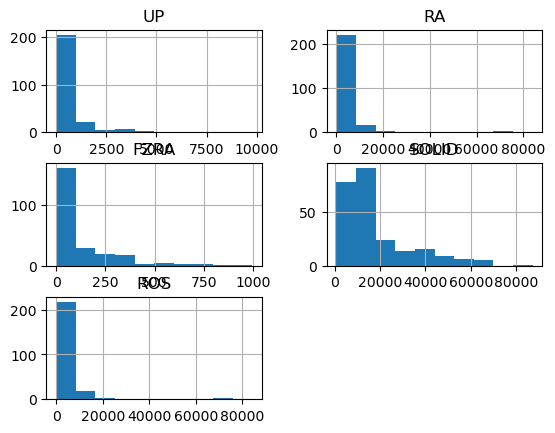

In [8]:
total_events[["UP","RA","FZRA","SOLID","ROS"]].hist()

In [61]:
def plot_event_counts(df, event_type="ROS", title="",
                      max_symbol_size=700,
                      symbol_color = '0.3',
                     ):

    params = {
        "ROS": {
            "title": "Winter Rain",
            "legend_counts": [80000, 10000, 1000],
            },
        "SOLID": {
            "title": "Winter Solid Precipitation",
            "legend_counts": [80000, 10000, 1000],
            },
        "Total": {
            "title": "All Precipitation",
            "legend_counts": [80000, 10000, 1000],
        },
    }

    title = params[event_type]["title"]
    legend_counts = params[event_type]["legend_counts"]
    
    ax = fig.add_subplot(projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180., 180., 50., 90.], ccrs.PlateCarree())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAND)

    ax.set_title(title, fontsize=20)

    symbol_size = max_symbol_size * df[event_type] / df[event_type].max()
    xy = ax.scatter(df.longitude, df.latitude, s=symbol_size, c=symbol_color, 
                    transform=ccrs.PlateCarree(), alpha=0.7)

    # Make the legend  This needs to be figured out
    # This is a little Kludgey
    legend_sizes = max_symbol_size * np.array(legend_counts) / df[event_type].max()

    # Get positions for Legend circles
    pos = ax.transAxes.transform([(0.8, 0.9), (0.8, 0.86), (0.8, 0.84)])
    inv = ax.transData.inverted()
    xpos, ypos = list(zip(*inv.transform(pos)))

    # Make Bounding Box
    rect = mpatches.Rectangle((0.76,0.82), height=0.15, width=0.15, transform=ax.transAxes,
                              edgecolor=None, facecolor="white", alpha=0.7)
    ax.add_patch(rect)

    # Add symbols
    ax.scatter(xpos, ypos, s=legend_sizes, c=symbol_color)

    # Add text
    ax.text(0.835, 0.96, "Events", transform=ax.transAxes, ha="center", va="top", fontsize=15)
    ax.text(0.90, 0.9, f"{legend_counts[0]}", transform=ax.transAxes, ha='right')
    ax.text(0.90, 0.86, f"{legend_counts[1]}", transform=ax.transAxes, ha='right')
    ax.text(0.90, 0.84, f"{legend_counts[2]}", transform=ax.transAxes, ha='right')

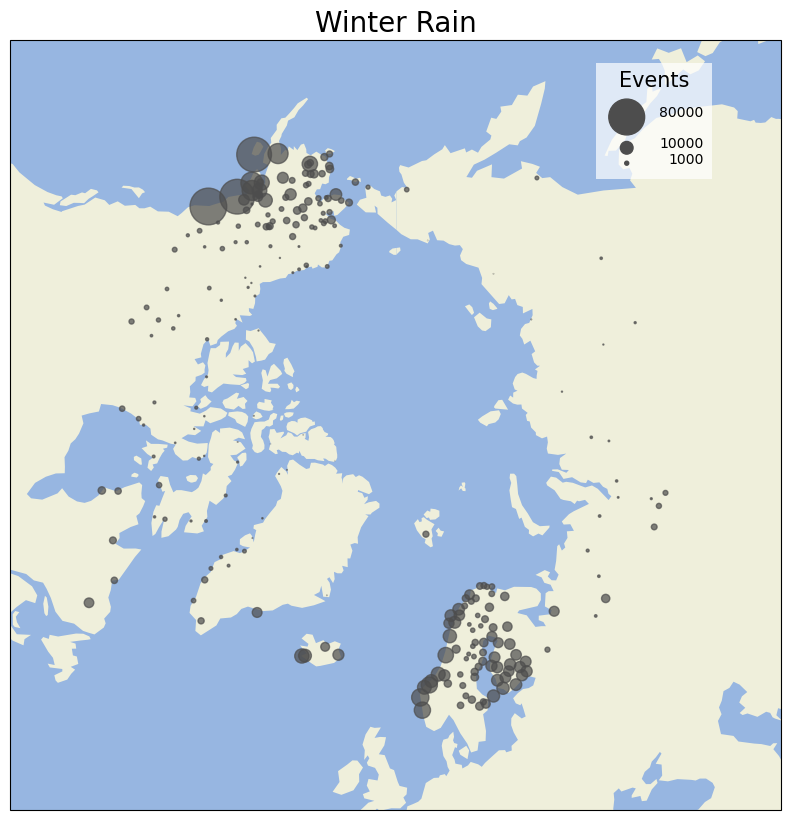

In [64]:
event_type = "ROS"
fig = plt.figure(figsize=(10,10))
ax = plot_event_counts(total_events, event_type, )
fig.savefig("aross.database.winter_ros_event_map.png")

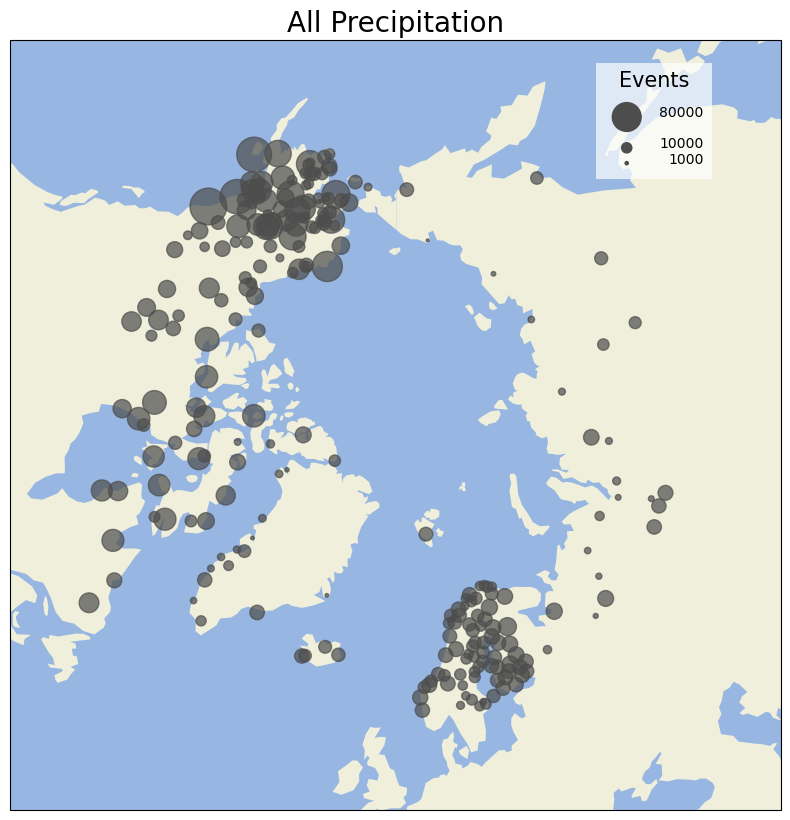

In [65]:
event_type = "Total"
fig = plt.figure(figsize=(10,10))
ax = plot_event_counts(total_events, event_type, )
fig.savefig("aross.database.winter_total_event_map.png")

## Make a heat map of events by month

In [78]:
def month_event_counts(df):
    """Returns a DataFrame containing events aggregated by month"""
    month_df = df[['UP', 'RA', 'FZRA', 'SOLID']].resample('M').sum()
    month_df['ROS'] = month_df['RA'] + month_df['FZRA']
    return month_df

In [79]:
data = []
indices = []
for fp in SURFOBS_HOURLY_PATH.glob("*.hourly.csv"):
    df = read_iowa_mesonet_file(fp)
    indices.append(get_stationid(df))
    data.append(month_event_counts(df))
df_all = pd.concat(data, axis=1, keys=indices).astype("float")

In [80]:
df_all.to_csv("aross.database.month_event_counts.csv")

In [81]:
def get_single_ptype(df, ptype: str):
    """Extracts columns for a single precipitation type"""
    return df.xs(ptype, level=1, axis=1)

In [86]:
RA = get_single_ptype(df_all, 'RA').replace(to_replace=0, value=np.nan)
FZRA = get_single_ptype(df_all, 'FZRA').replace(to_replace=0, value=np.nan)
SOLID = get_single_ptype(df_all, 'SOLID').replace(to_replace=0, value=np.nan)
ROS = get_single_ptype(df_all, 'ROS').replace(to_replace=0, value=np.nan)

In [87]:
def make_yticklabels(y, interval=5.):
    """Returns yticks and ylabels"""
    if y.dtype != 'float64':
        raise TypeError(f"Expects float, got {y.dtype}")
    ylabels = np.arange(y.min().round(-1), y.max().round(-1)+interval, interval)
    yticks = np.interp(ylabels, y, np.arange(len(y)))
    return yticks, ylabels

def heatmap(X, y=None, ax=None, aspect=0.4, cmap='viridis', **kwargs):
    """Plots a heat map with date labels
    
    :X: pd.DataFrame containing counts
    :y: alternative y labels, expects np.array
    """
    if ax is None:
        ax = plt.gca()
    
    x = X.index
    if y is None:
        y = X.columns
        yticks = np.arange(len(y))
        ylabels = y
    else:
        raise NotImplementedError("Alternative y-labels are not implemented yet")
        yticks, ylabels = make_yticklabels(y, interval=2.)
    data = X.T.values
    
    yticks = [0, 53,  76,  90,  94, 120, 146, 169, 244]
    ylabels = ['CA', 'FI', 'GL', 'IS', 'NO', 'RU', 'SE', 'US']
    xticks = np.where(X.index.month == 1)[0]
    xlabels = X.index.year[xticks]
    
    cmap = mcolors.ListedColormap(mpl.colormaps[cmap](np.linspace(0.,1.,5)))
    norm = mcolors.BoundaryNorm([1.,50.,100.,150.,200.], ncolors=cmap.N, clip=False)
    im = ax.imshow(data, aspect=aspect, cmap=cmap, **kwargs, origin='upper', norm=norm,
                   interpolation="none")
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, fontsize=15)
    ax.set_yticks(yticks)
    ax.set_yticklabels([])
    ax.set_yticks([(yticks[i]+yticks[i+1])*0.5 for i in range(len(yticks)-1)], minor=True)
    ax.set_yticklabels(ylabels, fontsize=20, minor=True)
    
    ax.grid(axis='y', which='major', linewidth=1, color='0.2')
    
    fig.colorbar(im, shrink=0.7, pad=0.01, extend='max')

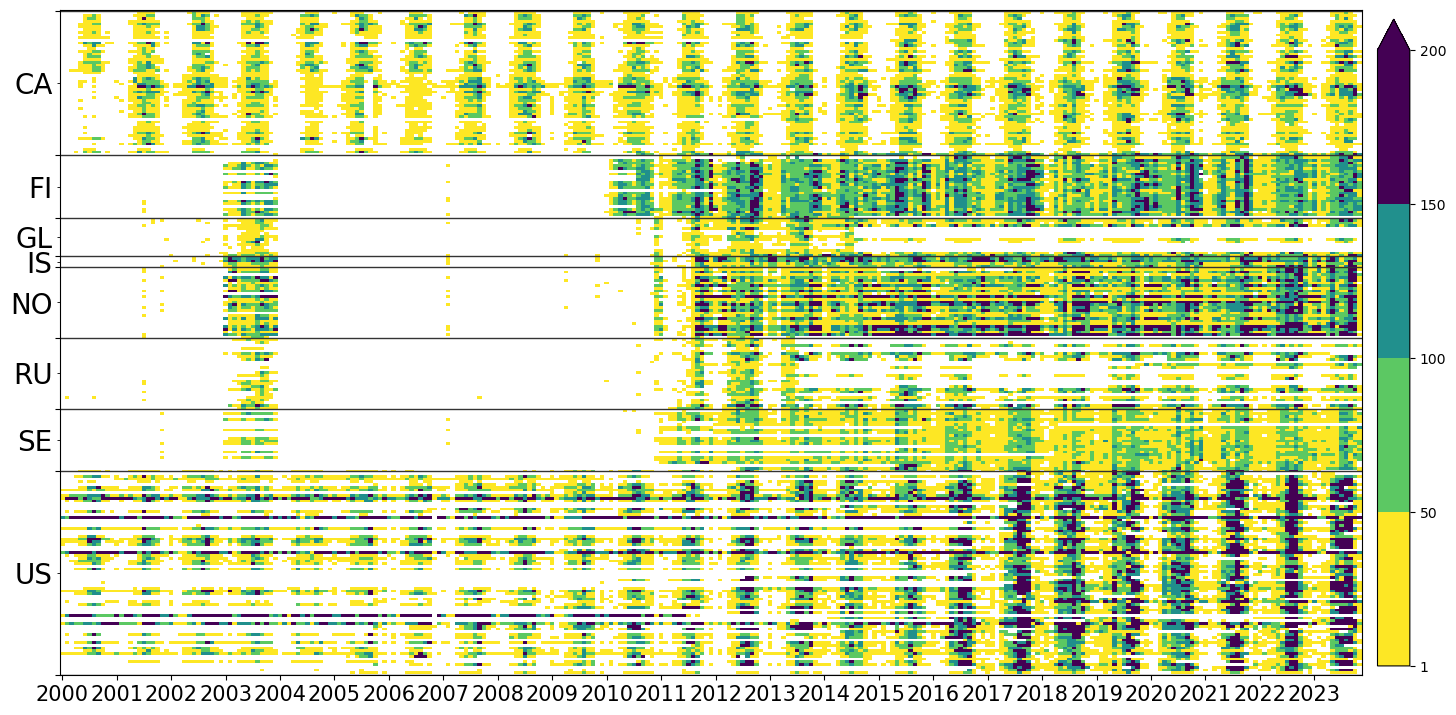

In [89]:
xs = 20
ys = 12
fig, ax = plt.subplots(figsize=(xs, ys))

country_order = stations.sort_values('country').index.values
heatmap(ROS.loc[slice("2000","2024"),country_order], cmap="viridis_r", aspect=ys/xs,)
fig.savefig('ros_timeseries_heatmap.png')

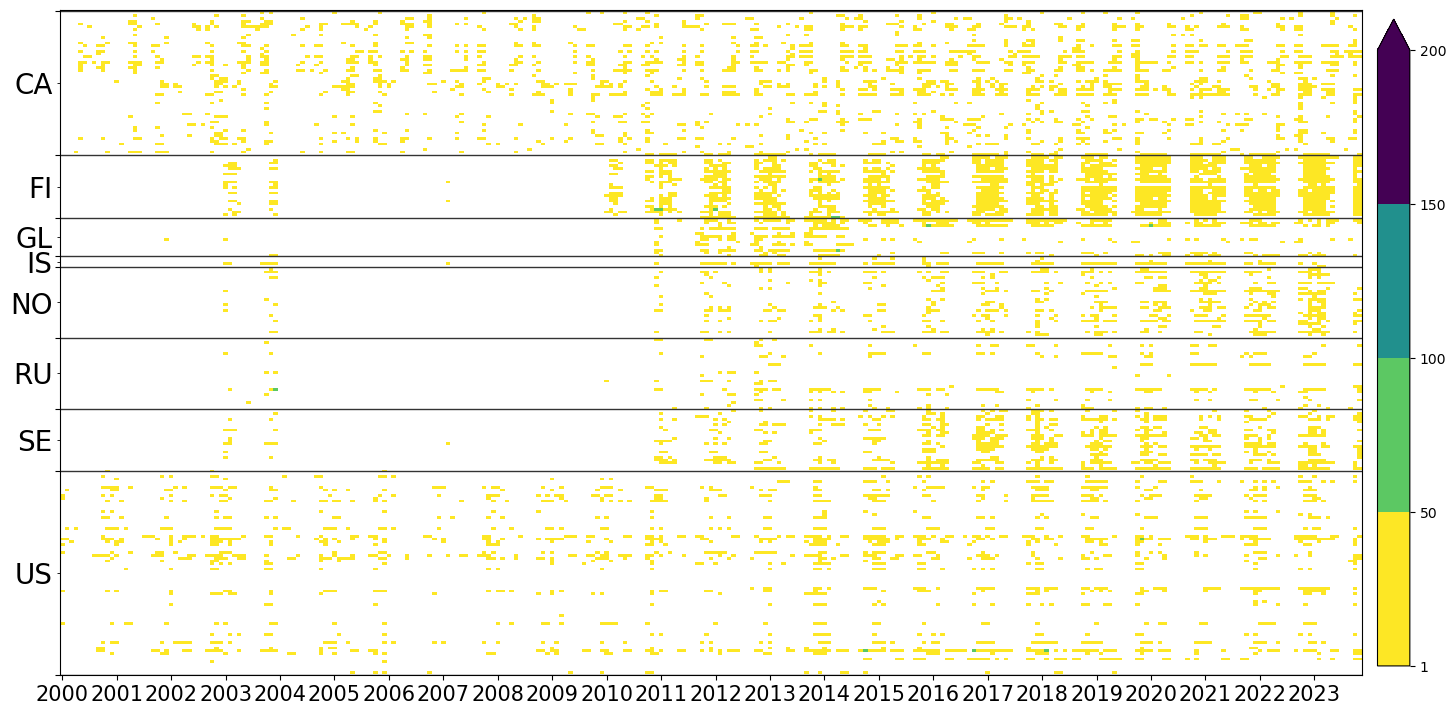

In [76]:
xs = 20
ys = 12
fig, ax = plt.subplots(figsize=(xs, ys))

country_order = stations.sort_values('country').index.values
heatmap(FZRA.loc[slice("2000","2024"),country_order], cmap="viridis_r", aspect=ys/xs)

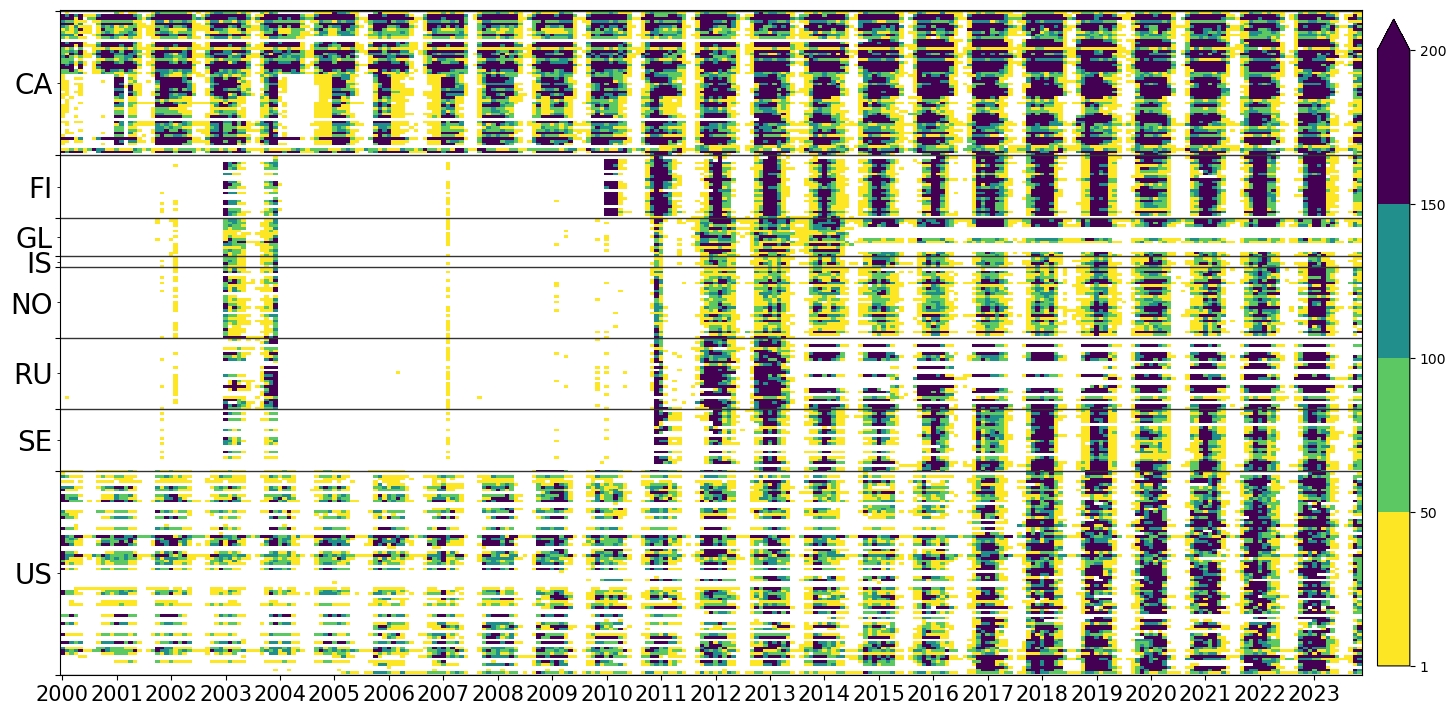

In [90]:
xs = 20
ys = 12
fig, ax = plt.subplots(figsize=(xs, ys))

country_order = stations.sort_values('country').index.values
heatmap(SOLID.loc[slice("2000","2024"),country_order], cmap="viridis_r", aspect=ys/xs)

## Plot monthly distribution of counts

In [ ]:
month_counts = RA.groupby(RA.index.month).sum().replace({0.: np.nan})
month_fraction = month_counts / month_counts.sum()
month_counts

In [ ]:
month_counts.max(axis=1)

In [ ]:
month_counts.sum(axis=1).plot.bar()

In [ ]:
def month_heatmap(X, y=None, ax=None, aspect=0.4, cmap='viridis', **kwargs):
    """Plots a heat map with date labels
    
    :X: pd.DataFrame containing counts
    :y: alternative y labels, expects np.array
    """
    if ax is None:
        ax = plt.gca()
    
    x = X.index
    if y is None:
        y = X.columns
        yticks = np.arange(len(y))
        ylabels = y
    else:
        raise NotImplementedError("Alternative y-labels are not implemented yet")
        yticks, ylabels = make_yticklabels(y, interval=2.)
    data = X.T.values
    
    yticks = [0, 53,  76,  90,  94, 120, 146, 169, 244]
    ylabels = ['CA', 'FI', 'GL', 'IS', 'NO', 'RU', 'SE', 'US']
    xticks = np.arange(12) + 0.5
    xlabels = ['J','F','M','A','M','J','J','A','S','O','N','D']
    
    cmap = mcolors.ListedColormap(mpl.cm.get_cmap(cmap)(np.linspace(0.,1.,)))
    norm = mcolors.BoundaryNorm([1.,1000.,2000.,3000.,4000.], ncolors=cmap.N, clip=False)
    im = ax.imshow(data, aspect=aspect, cmap=cmap, norm=norm, 
                   origin='upper', extent=[0.,12.,0.,244.],
                  interpolation='none', **kwargs)
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, fontsize=15)
    ax.set_yticks(yticks)
    ax.set_yticklabels([])
    ax.set_yticks([(yticks[i]+yticks[i+1])*0.5 for i in range(len(yticks)-1)], minor=True)
    ax.set_yticklabels(ylabels, fontsize=20, minor=True)
    
    ax.grid(axis='y', which='major', linewidth=1, color='0.2')
    
    fig.colorbar(im, shrink=0.7, pad=0.01, extend='max')
    

In [ ]:
xs = 12
ys = 12
fig, ax = plt.subplots(figsize=(xs, ys))

country_order = stations.sort_values('country').index.values
month_heatmap(month_counts[country_order], cmap="viridis_r", aspect=0.05)

fig.savefig('month_heatmap_ra.png')

## Look at relationship between RA, FZRA and SOLID, and T2m and D2m

In [ ]:
df_to_concat = []
for fp in SURFOBS_HOURLY_PATH.glob("*.hourly.csv"):
    df = read_iowa_mesonet_file(fp) 
    df_to_concat.append(df[df.RA | df.FZRA | df.SOLID].dropna(subset=['t2m', 'd2m']))
df_all = pd.concat(df_to_concat)
df_all.head()

In [ ]:
len(df_all)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,9))

xlim = ylim = (-60,60)

df_all[df_all.RA].plot.scatter(x='t2m', y='d2m', xlim=xlim, ylim=ylim, ax=ax[0], title='Rain')
ax[0].set_aspect('equal')
ax[0].grid(zorder=3)

df_all[df_all.FZRA].plot.scatter(x='t2m', y='d2m', xlim=xlim, ylim=ylim, ax=ax[1], title='Freezing Rain')
ax[1].set_aspect('equal')
ax[1].grid(zorder=3)

df_all[df_all.SOLID].plot.scatter(x='t2m', y='d2m', xlim=xlim, ylim=ylim, ax=ax[2], title='Solid')
ax[2].set_aspect('equal')
ax[2].grid(zorder=3)


### Look at the monthly plots

In [ ]:
station_paths = list(SURFOBS_HOURLY_PATH.glob("*.hourly.csv"))

In [ ]:
fp = station_paths[20]
df = read_iowa_mesonet_file(fp)

In [ ]:
df.head()

In [ ]:
df

### Read surface cover

In [ ]:
snow_cover = pd.read_csv("ims.surface_values.stations.csv", index_col=0, parse_dates=True)
snow_cover

In [ ]:
station in snow_cover

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12,5), sharex=True)



In [ ]:
columns = ["t2m","d2m","RA","FZRA","SOLID"]
nstation = 0
for fp in station_paths:
    df = read_iowa_mesonet_file(fp)
    df = df.loc[slice("2000",)]
    if df[columns].dropna().resample('Y').count().apply(lambda x: (x > 7884).all()).all():
        #print(fp)
        nstation += 1
print(nstation)

In [ ]:
len(station_paths)

In [ ]:
df.t2m.plot()

In [ ]:
import datetime as dt

window = 10  # days
fraction = 8

t2m_mean = df["t2m"].resample('D').mean()
iswinter = t2m_mean.rolling(dt.timedelta(days=window),min_periods=window).apply(lambda x: (x < 0.).sum() >= fraction)  

In [ ]:
year = "2006"

fig, ax = plt.subplots(figsize=(12,8))

t2m_mean.loc[year].plot(ax=ax)
iswinter.loc[year].plot(ax=ax)
ax.axhline(0,c='0.7')



In [ ]:
plt.scatter(t2m_mean.index.day_of_year, t2m_mean, s=1)